In [63]:
import numpy as np 
import pandas as pd 
import os
import cv2
from sklearn.svm import SVC
from skimage.feature import hog
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from skimage.color import rgb2gray
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from keras.applications import VGG16
from skimage.feature import hog
from skimage import data, exposure
from keras.models import Model
from keras import layers, losses

In [64]:
#path martim
path = "../../../../DadosProj/UTKFace/"
#path alex
#ath = "../../../data_project/UTKFace/"

files = os.listdir(path)
size = len(files)
print("Total samples:",size)
print(files[0])

Total samples: 23708
100_0_0_20170112213500903.jpg.chip.jpg


In [65]:
images = []
ages = []
genders = []
ethnicities = []
counter = 0

for file in files:
    if counter == 500:
        break
    
    image = cv2.imread(path+file)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, dsize=(200, 200))
    #image = image.astype('float32') / 255.0 #normalizing values on each point 
    image = image / 255.0

    images.append(image)
    delimit = file.split('_')
    ages.append(int(delimit[0]))
    # first number is age (0-116 possible values)
    genders.append(int(delimit[1]))
    # second number is gender (0 for male, 1 for female)
    ethnicities.append(int(delimit[2]))
    # third number is ethnicity (0 for white, 1 for black, 2 for asian, 3 for indian, 4 for any other ethnicity)

    counter += 1

In [66]:
def display_img(img, idx, isgray = False):
    print("Gender:", genders[idx], "Age:", ages[idx], "Ethnicity:", ethnicities[idx])
    if isgray:
        plt.imshow(img[idx],  cmap="gray")
    else:
        plt.imshow(img[idx],  cmap="gray")
    plt.show()

In [40]:
#display_img(images, 77)

hog

In [67]:
# Extract HOG features from the images
hog_features = []
for img in images:
    #hog_feature = hog(img, orientations=9, pixels_per_cell=(8, 8),
    #                cells_per_block=(2, 2), transform_sqrt=True, feature_vector=True, multichannel=True, channel_axis=2)
    hog_feature = hog(img, orientations=9, pixels_per_cell=(8, 8),
                    cells_per_block=(2, 2), transform_sqrt=True, feature_vector=True, channel_axis=2)
    
    hog_features.append(hog_feature)
hog_features = np.array(hog_features)

# Normalize the features to have zero mean and unit variance
mean = np.mean(hog_features, axis=0)
std = np.std(hog_features, axis=0)
hog_features_norm = (hog_features - mean) / std

In [68]:
X_train, X_test, y_train, y_test = train_test_split(hog_features_norm, genders, test_size=0.2, random_state=42)
#print("Samples in Training:",X_train.shape[0])
#print("Samples in Testing:",X_test.shape[0])

In [10]:
svc = SVC(kernel='linear')
svc.fit(X_train, y_train)

# Evaluate the classifier on the testing data
accuracy = svc.score(X_test, y_test)
print("Accuracy:", accuracy)

Accuracy: 0.81


Autoencoder

In [54]:
# for this the order is first the split of the data then using autoencoder on train_x

X_train, X_test, y_train, y_test = train_test_split(images, genders, test_size=0.2, random_state=42)

In [55]:
X_train = np.array(X_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2], 3))

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2], 3))

In [ ]:
# class Autoencoder(Model):
#   def __init__(self):
#     super(Autoencoder, self).__init__()

#     self.encoder = tf.keras.Sequential([
#       #didnt increase filter count in encoder and decrease equally in decoder because
#       #it can lead to overfitting

#       layers.Input(shape=(200, 200, 3)),
#       layers.Conv2D(64, (3,3), activation='relu', padding='same'),
#       layers.MaxPooling2D((2,2), padding='same'),
#       layers.Conv2D(32, (3,3), activation='relu', padding='same'),
#       layers.MaxPooling2D((2,2), padding='same'),
#       layers.Conv2D(16, (3,3), activation='relu', padding='same'),
#       layers.MaxPooling2D((2,2), padding='same'),])
    
#     self.decoder = tf.keras.Sequential([
#       #having conv2D here helps to avoid checkerboard artifacts
#       #which are alternating points of colors (like checkerboard)
#       #that are consequence of deconvolutioning an image and cause 
#       #loss of quality in final reconstruction

#       layers.Conv2D(16, (3,3), activation='relu', padding='same'),
#       layers.Conv2DTranspose(32, (3,3), activation='relu', padding='same'),
#       layers.Conv2DTranspose(64, (3,3), activation='relu', padding='same'),
#       layers.Conv2DTranspose(3, (3,3), activation='sigmoid', padding='same'),])
    
#       #sigmoid is required for final layer since we are evaluating with
#       #binary cross entropy
    
#       #maybe use strides in the layers too

#   def call(self, x):
#     encoded = self.encoder(x)
#     decoded = self.decoder(encoded)
#     return decoded

# # binary cross entropy is good for image feature extraction especially when images are normalized

# autoencoder = Autoencoder()
# autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [56]:
input = layers.Input(shape=(200, 200, 3))

# Encoder

#didnt increase filter count in encoder and decrease equally in decoder because
#it can lead to overfitting

x = layers.Conv2D(64, (3,3), activation='relu', padding='same')(input)
x = layers.MaxPooling2D((2,2), padding='same')(x)
x = layers.Conv2D(32, (3,3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2,2), padding='same')(x)
x = layers.Conv2D(16, (3,3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2,2), padding='same')(x)

# Decoder

#having conv2D here helps to avoid checkerboard artifacts
#which are alternating points of colors (like checkerboard)
#that are consequence of deconvolutioning an image and cause 
#loss of quality in final reconstruction

x = layers.Conv2D(16, (3,3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2,2))(x)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.UpSampling2D((2,2))(x)
x = layers.Conv2DTranspose(64, (3,3), activation='relu', padding='same')(x)
output = layers.Conv2DTranspose(3, (3,3), activation='sigmoid', padding='same')(x)


#maybe use strides in the layers too
#example:
#x = layers.Conv2D(16, (3,3), activation='relu', padding='same', strides = 2)(x)

# Autoencoder
autoencoder = Model(input, output)

# binary cross entropy is good for image feature extraction especially when images are normalized
autoencoder.compile(optimizer="adam", loss="binary_crossentropy")

In [57]:
#using validation_data is good for detecting overfitting as 
#it does early stopping when the performance is no longer improving

autoencoder.fit(x = X_train, 
                y = X_train,
                epochs = 2,
                shuffle = True,
                batch_size = 32,
                validation_data = (X_test, X_test),
)

Epoch 1/2
13/13 [==============================] - 22s 2s/step - loss: 0.6803 - val_loss: 0.6642
Epoch 2/2
13/13 [==============================] - 21s 2s/step - loss: 0.6585 - val_loss: 0.6474


In [58]:
#encoder = Model(inputs=input, outputs=autoencoder.get_layer("conv2d_transpose_55").output)
encoded_train = autoencoder.predict(X_train)
encoded_test = autoencoder.predict(X_test)

encoded_train = encoded_train.reshape((encoded_train.shape[0], -1))
encoded_test = encoded_test.reshape((encoded_test.shape[0], -1))

4/4 [==============================] - 2s 501ms/step


In [59]:
clf = SVC(kernel='linear')
clf.fit(encoded_train, y_train)

# Evaluate the classifier on the testing data
accuracy = clf.score(encoded_test, y_test)
print("Accuracy:", accuracy)

Accuracy: 0.73


Orb

Gender: 1 Age: 100 Ethnicity: 0


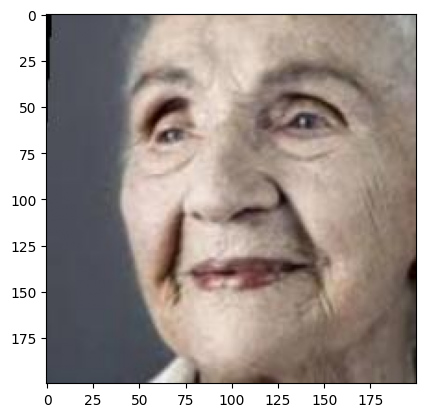

In [60]:
display_img(images, 6)

In [61]:
#orb works with greyscale images
grey_images = np.array([rgb2gray(image) for image in images]) #just in case we need the images in greys

Gender: 1 Age: 100 Ethnicity: 0


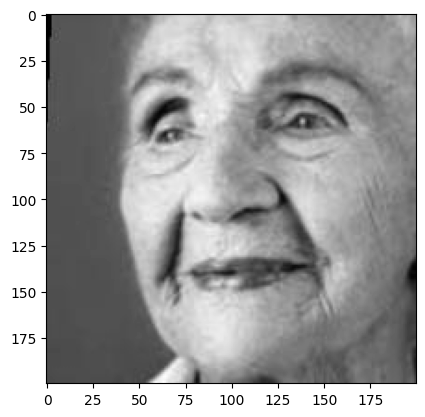

In [62]:
display_img(grey_images, 6, True)

In [41]:
#images = map(float, images)

In [43]:
#images

In [42]:
orb = cv2.ORB_create()

image = images[1].astype(np.uint8, copy=False)

#????? problema aqui
kp = orb.detect(image, None)
kp, des = orb.detectAndCompute(image, kp)

img2 = cv2.drawKeypoints(image, kp, None, color=(0,255,0), flags=0)

plt.imshow(img2, image.astype(np.uint8))

plt.show()

TypeError: 'map' object is not subscriptable

In [ ]:
#TODO
#retirar keypoints aleatoriamente de imagens com keypoints acima de um limiar decidido
#e ter uma quantidade minima definida para os keypoints

orb = cv2.ORB_create()
orb_features = []
Genders = []
MIN_KEYPOINTS = 500
MAX_KEYPOINTS = 500

for i, img in enumerate(images):
    
    keypoints, descriptors = orb.detectAndCompute(img, None)
    keypoints, descriptors = orb.compute(images[1], keypoints) #se houver problemas nesta linha ver esta duvida https://stackoverflow.com/questions/55128386/python-opencv-depth-of-image-unsupported-cv-64f
    
    if len(keypoints) < MIN_KEYPOINTS:
        continue  
    if len(keypoints) > MAX_KEYPOINTS:
        continue 
    
    orb_features.append(np.ndarray.flatten(descriptors))
    Genders.append(genders[i]) 

In [ ]:
for i, arr in enumerate(orb_features):
    print(f"Descriptor array {i} shape: {arr.shape}")

In [ ]:
mean = np.mean(orb_features, axis=0)
std = np.std(orb_features, axis=0)
orb_features_norm = (orb_features - mean) / std

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(orb_features_norm, Genders, test_size=0.2, random_state=42)
print("Samples in Training:",X_train.shape[0])
print("Samples in Testing:",X_test.shape[0])

In [ ]:
svc = SVC()
svc.fit(X_train, y_train)

accuracy = svc.score(X_test, y_test)
print("Accuracy:", accuracy)

cnn classification of genders using data from hog feature extraction

In [103]:
X_train, X_test, y_train, y_test = train_test_split(hog_features_norm, genders, test_size=0.2, random_state=42)

In [107]:
cnn = Sequential()

#????? problema aqui
cnn.add(layers.Reshape((144, 144, 1), input_shape=(20736,)))
#cnn.add(layers.Conv2D(16, (3, 3), padding='same', activation='relu', input_shape=X_train[1].shape))

cnn.add(layers.MaxPooling2D((2, 2)))
cnn.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu'))
cnn.add(layers.MaxPooling2D(2,2))
cnn.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
cnn.add(layers.MaxPooling2D(2,2))
cnn.add(Flatten())
cnn.add(Dense(64, activation='relu'))
cnn.add(layers.Dropout(0.2))

#output layer with 2 filters for number of classes the model will choose to do predictions
#and since gender is just binary classification sigmoid is appropriate
#when doing classification for age (wont be binary classification) then softmax is good choice
cnn.add(Dense(1, activation='sigmoid'))

cnn.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_3 (Reshape)         (None, 144, 144, 1)       0         
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 72, 72, 1)        0         
 g2D)                                                            
                                                                 
 conv2d_20 (Conv2D)          (None, 72, 72, 32)        320       
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 36, 36, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_21 (Conv2D)          (None, 36, 36, 64)        18496     
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 18, 18, 64)      

In [108]:
cnn.compile(optimizer="adam", loss="binary_crossentropy")

history = cnn.fit(X_train, y_train,
                    epochs=5,
                    batch_size=32,
                    validation_data=(X_test, y_test))

ValueError: Failed to find data adapter that can handle input: <class 'numpy.ndarray'>, (<class 'list'> containing values of types {"<class 'int'>"})

In [ ]:
loss, accuracy = cnn.evaluate(X_test, y_test)
print("Accuracy:", accuracy)